**Part 1: Depth Image Generation Using Off-the-Shelf Libraries**

In this part, you will use readily available tools to generate the depth image from the 2D image. 

It's recommended to use library: transformers (Hugging Face library). More information can be found in: https://huggingface.co/docs/transformers/v4.41.2/en/index. You can search and find the **depth estimation** in this website. If you are difficult to achieve this website, see the code in the tutorial 5 or use other tools.

Feel free to use other tools.

Requirement: generate the depth image from the given sample image **part1_sample.jpg**.

In [1]:
import sys
sys.path.append("/root/autodl-tmp/3DCVAssignment2/MiDaS")  # Replace with your actual MiDaS repository path

In [2]:
# Import necessary libraries
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

In [3]:
# Import the DPTDepthModel and transforms from the MiDaS repository
from midas.dpt_depth import DPTDepthModel  # Adjust the import if necessary
from midas.transforms import Resize, NormalizeImage, PrepareForNet

# --- Compose Class ---
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, sample):
        for transform in self.transforms:
            sample = transform(sample)
        return sample

# Define the path to the local model file
model_path = "dpt_large-midas-2f21e586.pt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/root/miniconda3/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


/tmp/ipykernel_1350/1975185849.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location="cpu")


torch.Size([1, 3, 384, 384])
torch.float32
tensor(-1., device='cuda:0') tensor(0.9384, device='cuda:0')


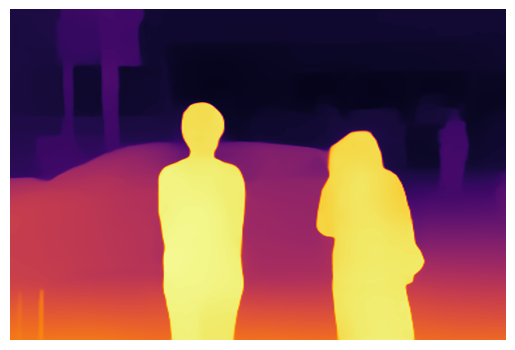

In [4]:
# Correctly initialize DPT-Large model
model = DPTDepthModel(path=None, backbone="vitl16_384", non_negative=True)
state_dict = torch.load(model_path, map_location="cpu")
model.load_state_dict(state_dict, strict=False)
model.to(device)
model.eval()

# Use custom Compose (combining MiDaS's built-in transforms)
transform = Compose([
    Resize(384, 384),
    NormalizeImage(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    PrepareForNet()
])

# Read image using OpenCV
img_cv = cv2.imread("part1_sample.jpg")
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

# Convert to float32 and scale to [0,1] (critical step!)
img_cv = img_cv.astype(np.float32) / 255.0

# Organize data in the format expected by MiDaS
sample = {"image": img_cv}

# Apply transforms
sample = transform(sample)
input_image = sample["image"]

# Convert to tensor and move to GPU
input_image = torch.from_numpy(input_image).unsqueeze(0).to(device)

print(input_image.shape)
print(input_image.dtype)
print(input_image.min(), input_image.max())

# Inference process
with torch.no_grad():
    prediction = model(input_image)

# Post-processing
predicted_depth = prediction.squeeze().cpu().numpy()

# Resize to original dimensions and normalize
height, width, _ = img_cv.shape
predicted_depth_resized = cv2.resize(predicted_depth, (width, height), interpolation=cv2.INTER_CUBIC)

# Normalize to [0,1]
min_val, max_val = np.min(predicted_depth_resized), np.max(predicted_depth_resized)
depth_normalized = (predicted_depth_resized - min_val) / (max_val - min_val + 1e-8)

# Visualize and save
plt.imshow(depth_normalized, cmap='inferno')
plt.axis('off')
plt.savefig("depth_output.jpg", bbox_inches='tight', pad_inches=0)
plt.show()

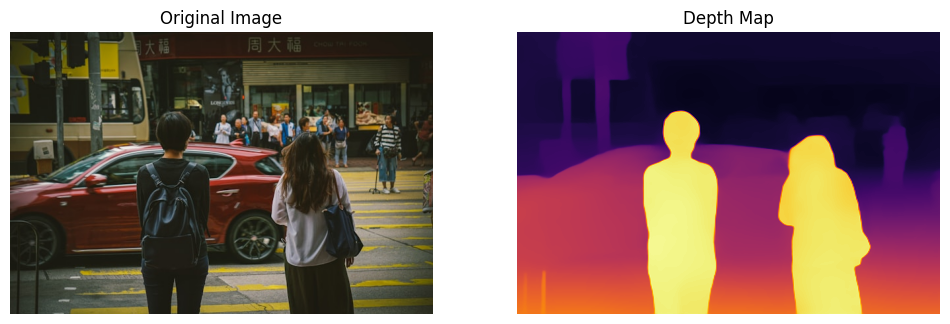

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the file
img = cv2.imread("part1_sample.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# depth_normalized
plt.figure(figsize=(12,5))

# Original
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')

# Depth
plt.subplot(1,2,2)
plt.imshow(depth_normalized, cmap='inferno')
plt.title('Depth Map')
plt.axis('off')

plt.show()


**Part 2: Reproduce the Network from the Paper**

In this part, you are required to read and understand the given network architecture and implement it using Pytorch. **You need to complete the coarse network and the refined network separately. You do not need to connect the two networks. You don’t need to train your network. You also need to complete the traning loss section (scale invariant log error).** Please use the data with size 3x304x228 as input.

Network Architecture: **3DCV_10_Sv3D.pptx, Slide 43** or find **Figure 1** in the paper 'Depth Map Prediction from a Single Image using a Multi-Scale Deep Network'

Loss: See the **loss.jpg** in ispace or find **3.2 Scale-Invariant Error** in the paper 'Depth Map Prediction from a Single Image 
using a Multi-Scale Deep Network'

Reference:

David Eigen, Christian Puhrsch, and Rob Fergus. Depth 
map prediction from a single image using a multi-scale dee 
network. In NeurIPS, 2014. 2

Please add the relu function after the convolutional layer.

Your can use the below structure. Feel free to write down your own structure.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
pseudo_image_data = torch.randn(1, 3, 304, 228) # Size: (Batchsize = 1, Channel = 3, Height = 304, Width = 228)

In [8]:
class coarse(nn.Module):
    def __init__(self):
        super(coarse, self).__init__()

        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(256 * 19 * 14, 4096)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(4096, 38 * 28)  # updated size

    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        x = x.view(-1, 1, 38, 28)

        return x

In [9]:
class refined(nn.Module):
    def __init__(self):
        super(refined, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 63, kernel_size=9, stride=4, padding=4) # updated stride
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Input channels: coarse output (1) + previous conv output (63)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=5, stride=1, padding=2)
    
    def forward(self, x, coarse_output):
        
        conv1_out = F.relu(self.conv1(x))
        conv1_out = self.pool1(conv1_out)

        # Concatenate coarse output with conv1_out along the channel dimension
        merged = torch.cat((conv1_out, coarse_output), 1)

        x = F.relu(self.conv2(merged))
        x = self.conv3(x)
        
        return x

In [10]:
class ScaleInvariantError(nn.Module):
    def __init__(self):
        super(ScaleInvariantError, self).__init__()

    def forward(self, pred, target):
        eps = 1e-6  # avoid log(0)
        pred = torch.clamp(pred, min=eps)
        target = torch.clamp(target, min=eps)
        
        log_diff = torch.log(pred) - torch.log(target)
        
        n = log_diff.numel()
        term1 = torch.sum(log_diff ** 2) / n
        term2 = (torch.sum(log_diff) ** 2) / (n ** 2)

        loss = term1 - term2
        
        return loss

If you find any mistakes please email TA.

In [11]:
# Test network structures
coarse_net = coarse()
refined_net = refined()
scale_invariant_loss = ScaleInvariantError()

# Generate pseudo output for coarse network
coarse_output = coarse_net(pseudo_image_data)

# Generate pseudo refined network output
refined_output = refined_net(pseudo_image_data, coarse_output)

# Generate pseudo target
pseudo_target = torch.abs(torch.randn_like(refined_output))

# Calculate loss
loss = scale_invariant_loss(refined_output, pseudo_target)

print("Coarse output shape:", coarse_output.shape)
print("Refined output shape:", refined_output.shape)
print("Loss:", loss.item())

Coarse output shape: torch.Size([1, 1, 38, 28])
Refined output shape: torch.Size([1, 1, 38, 28])
Loss: 16.500946044921875
